In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import tensorflow as tf
import numpy as np
import torch
import math
import pickle
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, GRU
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Layer, Flatten, LeakyReLU
from keras.layers import Input, Reshape, Dense, Lambda
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import mse, binary_crossentropy
from keras import regularizers, activations, initializers, constraints
from keras.constraints import Constraint
from keras.callbacks import History
from keras.utils import plot_model

In [63]:
ROA = '/content/drive/MyDrive/df_ROA_postu.pkl'
ROC = '/content/drive/MyDrive/df_ROC_postu.pkl'
RGA = '/content/drive/MyDrive/df_RGA_postu.pkl'
RGC = '/content/drive/MyDrive/df_RGC_postu.pkl'
with open(ROA, 'rb') as file:
    dataROA = pickle.load(file)
with open(ROC, 'rb') as file:
    dataROC = pickle.load(file)
with open(RGA, 'rb') as file:
    dataRGA = pickle.load(file)
with open(RGC, 'rb') as file:
    dataRGC = pickle.load(file)

In [64]:
dataROA = dataROA.reset_index(drop=True)
dataROC = dataROC.reset_index(drop=True)
dataRGA = dataRGA.reset_index(drop=True)
dataRGC = dataRGC.reset_index(drop=True)
dataRGC.shape

(115, 6)

In [65]:
dataROA = dataROA.drop(dataROA[dataROA['Indice_VIS'] == '-'].index)
dataROC = dataROC.drop(dataROC[dataROC['Indice_VIS'] == '-'].index)
dataRGA = dataRGA.drop(dataRGA[dataRGA['Indice_VIS'] == '-'].index)
dataRGC = dataRGC.drop(dataRGC[dataRGC['Indice_VIS'] == '-'].index)

dataROA = dataROA.drop(dataROA[dataROA['Indice_VEST'] == '-'].index)
dataROC = dataROC.drop(dataROC[dataROC['Indice_VEST'] == '-'].index)
dataRGA = dataRGA.drop(dataRGA[dataRGA['Indice_VEST'] == '-'].index)
dataRGC = dataRGC.drop(dataRGC[dataRGC['Indice_VEST'] == '-'].index)

In [66]:
dataROA.columns

Index(['id', 'x', 'y', 'Indice_VIS', 'Indice_SOM', 'Indice_VEST'], dtype='object')

In [67]:
labels = dataRGC['Indice_VEST']/100

In [68]:
X = dataRGC.drop(columns = ['id','Indice_VIS','Indice_VEST','Indice_SOM'])
X = X.reset_index(drop=True)
X.shape

(115, 2)

In [69]:
X_3d = np.empty((X.shape[0], X.shape[1], len(X.values[0][0])), dtype=object) #conversió dades en una matriu numpy
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        X_3d[i, j] = tf.constant(X.values[i][j])

In [70]:
X_3d[0].shape #cada mostra te mida 2x1199 (dos files x i y)

(2, 1199)

In [71]:
#funcio que redimensiona les dades a 2d per poder aplicar minmaxscaler, NORM PER CARACTERÍSTIQUES
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [72]:
scaler = MinMaxScaler3D()
X_2d = scaler.fit_transform(X_3d)

In [73]:
X_2d[0][0]

array([0.33198846, 0.33733468, 0.34922202, ..., 0.21417513, 0.21318664,
       0.21256159])

In [74]:
X_train = X_2d[:94].astype(np.float32)
y_train = labels[:94].astype(np.float32)
y_Train = y_train.values
X_test = X_2d[94:].astype(np.float32)
y_test = labels[94:].astype(np.float32)
y_test = y_test.values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(94, 2, 1199) (94,) (21, 2, 1199) (21,)


In [75]:
class Autoencoder:

    def __init__(self, x_sz, y_sz, z_dim=64, variational=False):
        self.x_sz = x_sz #dimensions de l'input
        self.y_sz = y_sz
        self.z_dim = z_dim
        self.variational = variational
        self.encoder = None
        self.decoder = None
        self.autoencoder = None

    def build_encoder(self):
        input_data = Input(shape=(self.x_sz,self.y_sz,))
        encoded = Dense(256, activation='relu')(input_data)
        encoded = Dense(128, activation='relu')(encoded)
        encoded = Dense(self.z_dim, activation='relu')(encoded)
        return input_data, encoded

    def build_decoder(self, encoded):
        decoded = Dense(128, activation='relu')(encoded)
        decoded = Dense(256, activation='relu')(decoded)
        decoded = Dense((self.y_sz), activation='sigmoid')(decoded)
        return decoded

    def train_autoencoder(self, x_train):
        input_data, encoded = self.build_encoder()
        decoded = self.build_decoder(encoded)

        self.autoencoder = Model(input_data, decoded)
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.encoder = Model(input_data, encoded)
        decoder_input = Input(shape=(self.z_dim,))
        decoder_output = self.build_decoder(decoder_input)
        self.decoder = Model(decoder_input, decoder_output)

In [76]:
autoencoder = Autoencoder(x_sz=X_train.shape[-2], y_sz=X_train.shape[-1], z_dim=64)
autoencoder.train_autoencoder(X_train)

In [77]:
#reconstruccions del decoder
decoded_imgs = autoencoder.autoencoder.predict(X_test)

1/1 [==============================] - 0s 243ms/step


In [78]:
# Calcular el MSE promig
mse = np.mean(np.square(X_test - decoded_imgs))
print("MSE promig: %.4f" % mse)

MSE promig: 0.0631


In [79]:
X_train_reduced = autoencoder.encoder.predict(X_train)
X_test_reduced = autoencoder.encoder.predict(X_test)

1/1 [==============================] - 0s 27ms/step


In [80]:
X_train_reduced.shape

(94, 2, 64)

In [81]:
X_train_reduced = np.reshape(X_train_reduced,(X_train_reduced.shape[0],X_train_reduced.shape[2],X_train_reduced.shape[1]))
X_test_reduced = np.reshape(X_test_reduced,(X_test_reduced.shape[0],X_test_reduced.shape[2],X_test_reduced.shape[1]))

In [82]:
def build_model(lr=0.001, units_gru=128, units_gru_2=64, units_dense=32):
    model = tf.keras.Sequential()

    # Capa GRU 1 para procesar las secuencias temporales
    model.add(GRU(units_gru, return_sequences=True, input_shape=(X_train_reduced.shape[1], X_train_reduced.shape[2])))

    # Capa GRU 2 para capturar características a diferentes escalas
    model.add(GRU(units_gru_2, return_sequences=False))

    # Capa totalmente conectada para procesar características a nivel de píxeles
    model.add(Dense(units_dense, activation='relu'))

    # Capa totalmente conectada final con función de activación sigmoide para clasificación binaria
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Crear el modelo
model = build_model()

# Mostrar el resumen del modelo
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 64, 128)           50688     
                                                                 
 gru_10 (GRU)                (None, 64)                37248     
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 90,049
Trainable params: 90,049
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(X_train_reduced, y_train, epochs=10, batch_size=16, validation_data=(X_test_reduced, y_test))

Epoch 1/10
6/6 [==============================] - 6s 257ms/step - loss: 0.2193 - mae: 0.4580 - val_loss: 0.1876 - val_mae: 0.4246
Epoch 2/10
6/6 [==============================] - 1s 97ms/step - loss: 0.2082 - mae: 0.4296 - val_loss: 0.1573 - val_mae: 0.3739
Epoch 3/10
6/6 [==============================] - 1s 101ms/step - loss: 0.2074 - mae: 0.4176 - val_loss: 0.1628 - val_mae: 0.3843
Epoch 4/10
6/6 [==============================] - 1s 149ms/step - loss: 0.2071 - mae: 0.4241 - val_loss: 0.1691 - val_mae: 0.3955
Epoch 5/10
6/6 [==============================] - 1s 148ms/step - loss: 0.2065 - mae: 0.4236 - val_loss: 0.1673 - val_mae: 0.3923
Epoch 6/10
6/6 [==============================] - 1s 153ms/step - loss: 0.2062 - mae: 0.4226 - val_loss: 0.1668 - val_mae: 0.3914
Epoch 7/10
6/6 [==============================] - 1s 157ms/step - loss: 0.2065 - mae: 0.4217 - val_loss: 0.1656 - val_mae: 0.3892
Epoch 8/10
6/6 [==============================] - 1s 151ms/step - loss: 0.2080 - mae: 0.420

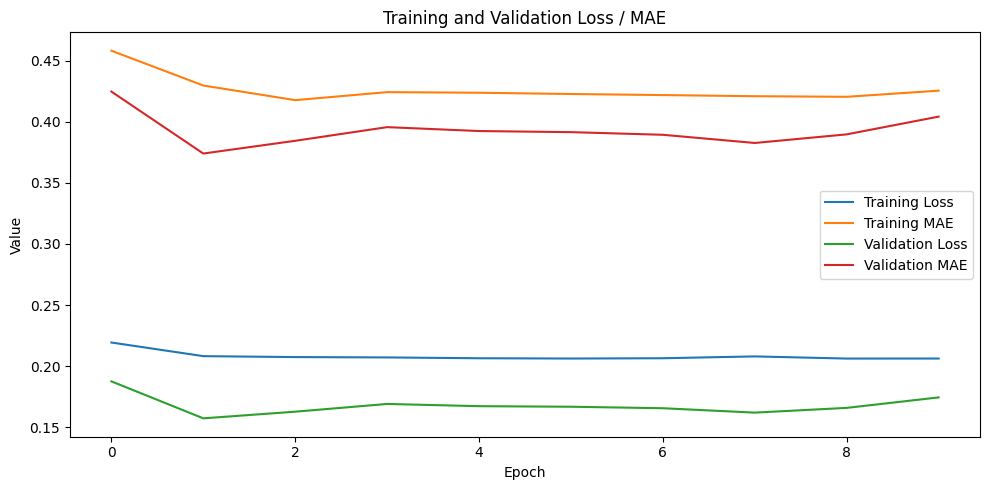

In [84]:
loss = history.history['loss']
mae = history.history['mae']
val_loss = history.history['val_loss']
val_mae = history.history['val_mae']

plt.figure(figsize=(10, 5))

plt.plot(loss, label='Training Loss')
plt.plot(mae, label='Training MAE')
plt.plot(val_loss, label='Validation Loss')
plt.plot(val_mae, label='Validation MAE')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Loss / MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [86]:
y_pred = model.predict(X_test_reduced)
for i in range(len(y_pred)):
  print(y_pred[i],"        ", y_test[i])

1/1 [==============================] - 0s 45ms/step
[0.61353284]          1.0
[0.61214185]          1.0
[0.67903984]          0.0
[0.6183259]          1.0
[0.62093383]          1.0
[0.61723983]          1.0
[0.6230222]          1.0
[0.60034037]          0.0
[0.613134]          0.0
[0.6046908]          0.83178806
[0.62135875]          0.83178806
[0.5865107]          1.0
[0.613028]          1.0
[0.6088542]          1.0
[0.6265381]          1.0
[0.6190733]          1.0
[0.6163875]          1.0
[0.612649]          1.0
[0.6163828]          1.0
[0.61895216]          1.0
[0.62021303]          1.0
